## Audiovideo Overlay and Sobel Filter

This example will show how to:
1) Read an frame from the HDMI
2) Save it as an image and display it in the notebook
3) Do some simple image processing in Python (Gray Scale conversion, and Sobel filter)

A HDMI input source is required for this example. This should be on, and connected to the board before running the code below. (The cell below will time-out if a source is not detected).

In [1]:
from pynq import Overlay
from pynq.video import Frame, HDMI
from IPython.display import Image

# HDMI enabled overlay 
Overlay("audiovideo.bit").download()

# Start HDMI and give some time for synchronization - we wait here for 10 seconds to be 
# overly conservative, since synchronization time depends on the video input source.
hdmi=HDMI('in')
hdmi.start()

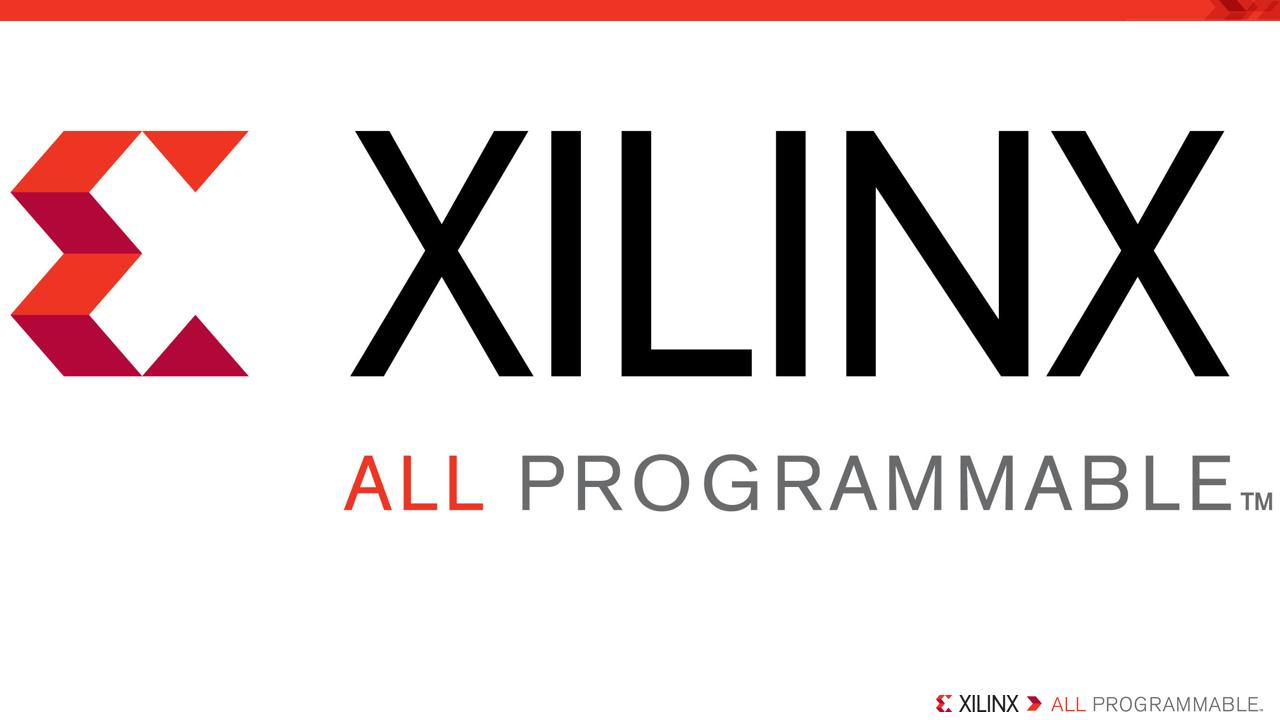

In [2]:
# save frame and display JPG here
frame = hdmi.frame()
orig_img_path = '/home/xpp/jupyter_notebooks/Examples/data/orig.jpg'
frame.save_as_jpeg(orig_img_path)

Image(filename=orig_img_path)

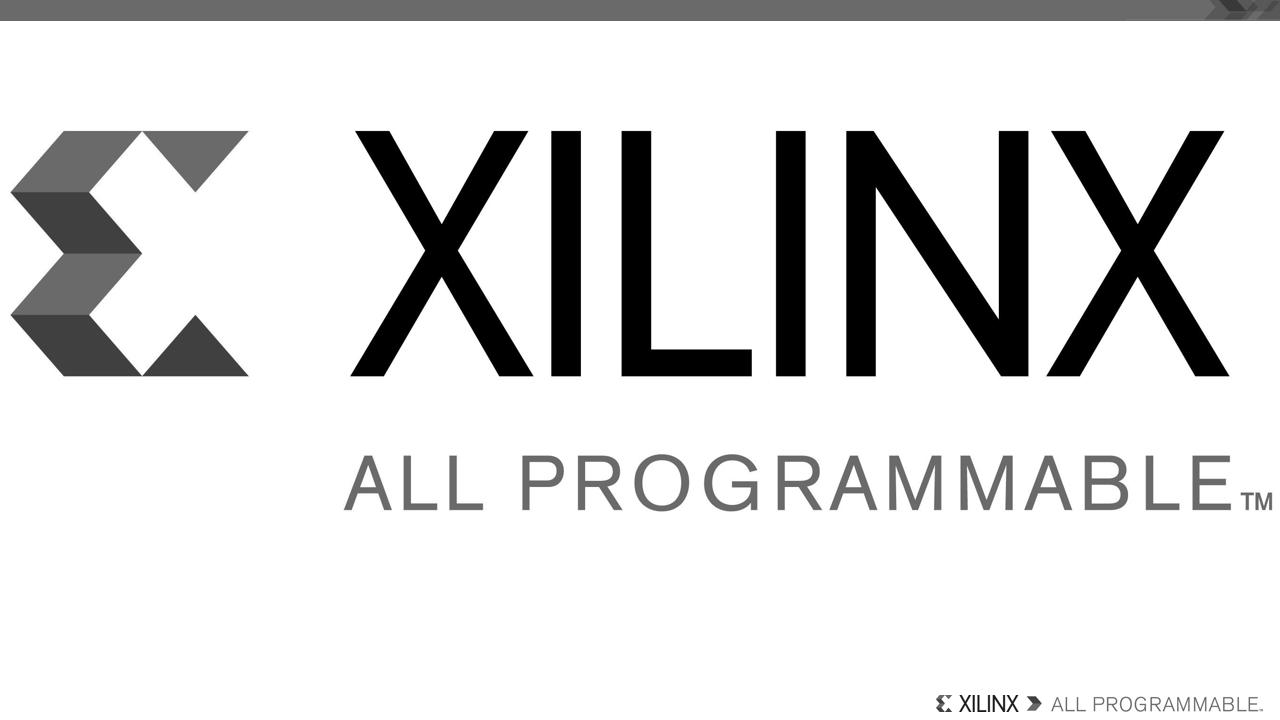

In [3]:
# Gray Scale filter
# Access the frame contents (a bytearray) directly for optimized processing time
# This cell should take ~20s to complete

from pynq.video import video_const


grayframe = frame
frame_i = grayframe.frame

height = hdmi.frame_height()
width = hdmi.frame_width()

for y in range(0, height):
    for x in range(0, width):
        
        offset = 3 * (y * video_const.MAX_FRAME_WIDTH + x)
        
        gray = round((0.299*frame_i[offset+2]) + (0.587*frame_i[offset+0]) 
                      + (0.114*frame_i[offset+1]))          
        frame_i[offset+0] = gray     
        frame_i[offset+1] = gray
        frame_i[offset+2] = gray
 
gray_img_path = '/home/xpp/jupyter_notebooks/Examples/data/gray.jpg'
grayframe.save_as_jpeg(gray_img_path)
Image(filename=gray_img_path)

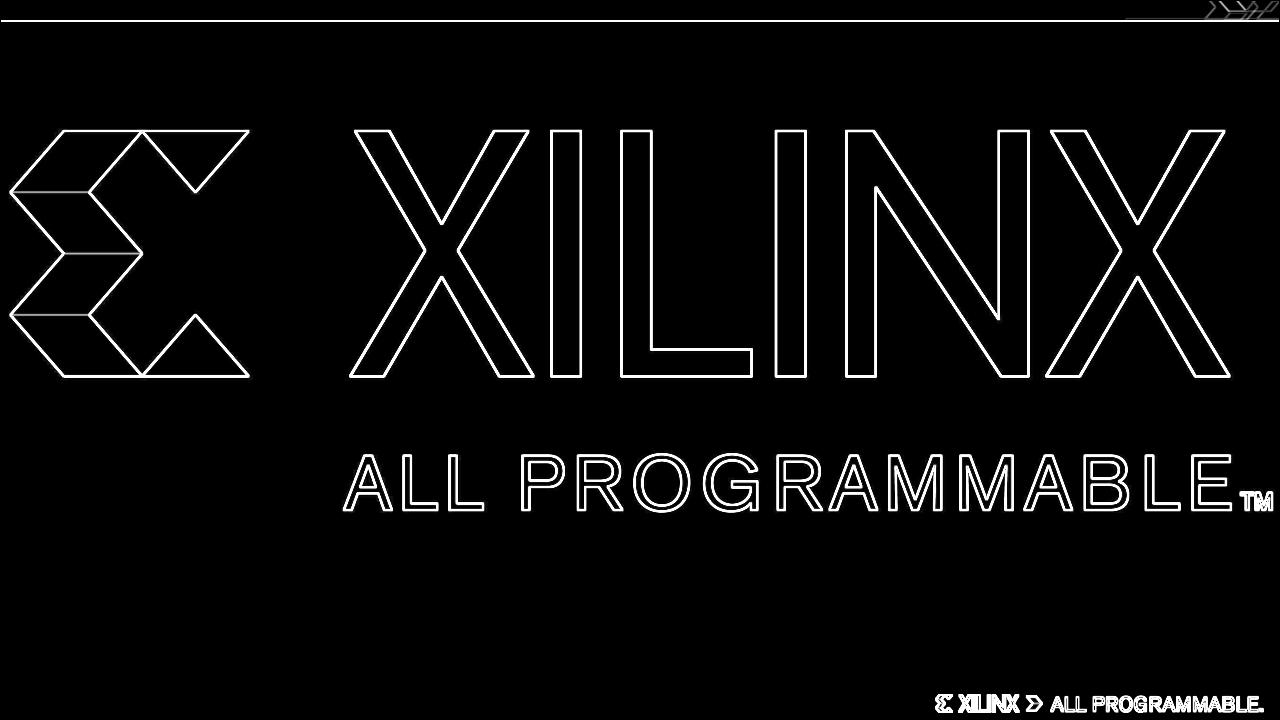

In [4]:
# Sobel filter
# Access the frame contents (a bytearray) directly for optimized processing time
# This cell should take ~30s to complete

#Compute the Sobel Filter output
#Gx = -1 0 +1     Gy= +1 +2 +1
#     -2 0 +2          0  0  0
#     -1 0 +1         -1 -2 -1

sobel = Frame(width, height)
frame_i = frame.frame

for y in range(1,height-1):
    for x in range(1,width-1):
        
        offset = 3 * (y * video_const.MAX_FRAME_WIDTH + x)
        upper_row_offset = offset - video_const.MAX_FRAME_WIDTH*3
        lower_row_offset = offset + video_const.MAX_FRAME_WIDTH*3       
        
        gx = abs(-frame_i[lower_row_offset-3] + frame_i[lower_row_offset+3] -2*frame_i[offset-3] 
                 +2*frame_i[offset+3] -frame_i[upper_row_offset-3] + frame_i[upper_row_offset+3])
        gy = abs(frame_i[lower_row_offset-3] + 2*frame_i[lower_row_offset] + frame_i[lower_row_offset+3] 
                 -frame_i[upper_row_offset-3] -2*frame_i[upper_row_offset] - frame_i[upper_row_offset+3])        
       
        grad = gx + gy
        if grad > 255:
            grad = 255                    
        sobel.frame[offset+0] = grad     
        sobel.frame[offset+1] = grad
        sobel.frame[offset+2] = grad
        
sobel_img_path = '/home/xpp/jupyter_notebooks/Examples/data/sobel.jpg'
sobel.save_as_jpeg(sobel_img_path)

Image(filename=sobel_img_path)

In [5]:
# free up space from different frames
del sobel
del grayframe
del hdmi